Deep learning allows computational models that are composed of multiple processing layers to learn representations of data with multiple levels of abstraction. Deep learning discovers intricate structure in large data sets by using the backpropagation algorithm to indicate how a machine should change its internal parameters that are used to compute the representation in each layer from the representation in the previous layer.

In [0]:
# get data from OpenI 
!unzip "Open_I_abd_vs_CXRs.zip"

In [0]:
# ##This notebook is built around using tensorflow as the backend for keras
# !KERAS_BACKEND=tensorflow python -c "from keras import backend"

In [0]:
#load libraries

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

Our dataset consists of 75 images, split roughly in
half, with 37 of the abdomen and 38 of the chest. The data is derived from OpenI, a searchable online repository of medical images from published PubMed Central articles, hosted by the National Institutes of Health (https://openi.nlm.nih.gov). 

In [0]:
train_data_dir = '/content/Open_I_abd_vs_CXRs/TRAIN' #location of training data
validation_data_dir = '/content/Open_I_abd_vs_CXRs/VAL' #location of validation data

**Images devided into training and validation. In this example, we put 65 cases into training and 10 into validation**

In [0]:
# dimensions of our images.
img_width, img_height = 299, 299

# setting values for a number of images for traing and validation
nb_train_samples = 65
nb_validation_samples = 10

epochs = 20 # number of passes through training data
batch_size = 5  #numer of images processing at the same time

Image Preprocessing and Augmentation

We then preprocess and specify augmentation options, which include transformations and other variations to the image, which can help preempt overfitting or memorization of training data, and have shown to increase accuracy and generalization of CNNs. While augmentation can be done in advance, Keras has an image data generator, which can perform on a fly augmentation, such as rotations, translation,
zoom, shearing, and flipping, just before they are fed to the network. 

In [0]:
train_datagen = ImageDataGenerator(
        rescale=1./255,            # normalize pixel values to [0,1] to aid CNN processing
        shear_range=0.2,           # 0-1 range for shearing
        zoom_range=0.2,            # 0-1 range for zoom
        rotation_range=20,         # 0-180 range, degrees of rotation
        width_shift_range=0.2,     # 0-1 range horizontal translation
        height_shift_range=0.2,    # 0-1 range vertical translation
        horizontal_flip=True)      # True or False

val_datagen = ImageDataGenerator(rescale=1./255)       # normalize pixel values to [0,1]

**Defining the training and
validation generator and fitting
the model**

Directory, image size, batch size already specified above. Class mode is set to 'binary' for a 2-class problem. Generator randomly shuffles and presents images in batches to the network.

In [22]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = train_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 65 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


In machine learning, **transfer learning** refers to application of a process suited for one specific task to a different problem.  For example, a machine learning algorithm trained to recognize every day color images, such as animals, could be used to
classify radiographs. The idea is that all images share similar features such as edges and blobs, which aids transfer learning. In addition, deep neural networks often require large datasets
(in the millions) to properly train. As such, starting with weights from pretrained networks will often perform better than random initialization if using small datasets. In medical imaging classification tasks, this is often the case, as it may be difficult to annotate a large dataset to train from scratch. There are many strategies for transfer learning, which include freezing layers and training on later layers, and using a low learning rate. Some of this optimization is frequently done by trial and error, so you may have to experiment with different options.

We build the pretrained Inception V3 network, a popular CNN that achieved a top 5 accuracy of greater than 94% on the ILSVRC. In Keras, the network can be built in one line of code (Fig. 3). Since there are two possible categories (abdominal or chest radiograph), we compile the model using binary cross-entropy loss.

We remove the final (top) fully connected layers of the pretrained Inception V3 model that was intended for a 1000-class problem in ImageNet, and insert a few additional layers with random initialization, so they can learn from the new medical data provided. We then fine-tune the entire model using a very low learning rate (0.0001), as not to rapidly perturb the weights that are already relatively well optimized.

In [0]:
# Build an Inseption V3 network, remove top layer from the original network, use pre-trained weights from ImageNet
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

Add new layers on top of the original model. There are many possibilities, but here, we add a global average pooling layer, a fully connected layer with 256 nodes, dropout, and sigmoid activation. We also define an optimizer; in this case, it is the Adam optimizer with default
settings

In [0]:
model_top = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None)),  
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid')) 

model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

There are many available gradient descent optimization algorithms, which minimize a particular objective function. In the example, we use the **Adam optimize**r with commonly used settings and **binary cross-entropy loss**. Also, we use low learning rate (lr) for transfer learning.

In [0]:
model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])

Fine-tune the pretrained Inception V3 model using the data generator. Specify steps per epoch (number of samples/batch_size) 

 The training and validation loss both decrease, which indicates that the model is "learning"

In [26]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size)

Epoch 1/20
13/13 [==============================] - 101s 8s/step - loss: 0.5636 - acc: 0.7077 - val_loss: 0.1904 - val_acc: 1.0000
Epoch 2/20
13/13 [==============================] - 79s 6s/step - loss: 0.0900 - acc: 0.9692 - val_loss: 0.0371 - val_acc: 1.0000
Epoch 3/20
13/13 [==============================] - 79s 6s/step - loss: 0.0510 - acc: 1.0000 - val_loss: 0.0123 - val_acc: 1.0000
Epoch 4/20
13/13 [==============================] - 78s 6s/step - loss: 0.3369 - acc: 0.8769 - val_loss: 0.0705 - val_acc: 1.0000
Epoch 5/20
13/13 [==============================] - 79s 6s/step - loss: 0.1336 - acc: 0.9538 - val_loss: 0.0284 - val_acc: 1.0000
Epoch 6/20
13/13 [==============================] - 79s 6s/step - loss: 0.0254 - acc: 1.0000 - val_loss: 0.0324 - val_acc: 1.0000
Epoch 7/20
13/13 [==============================] - 78s 6s/step - loss: 0.2665 - acc: 0.9385 - val_loss: 0.0129 - val_acc: 1.0000
Epoch 8/20
13/13 [==============================] - 79s 6s/step - loss: 0.1613 - acc: 0.9

Sample Python code to plot training data. Accuracy
increases and loss decreases over time for the training and validation data. The loss and accuracy values are stored in arrays, which can be plotted using Matplotlib

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


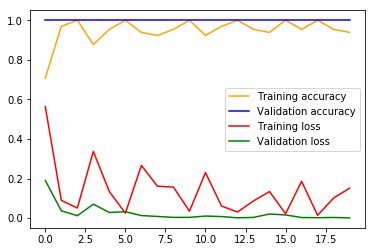

In [27]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

Steps for performing inference on test cases, including displaying of image and generating a prediction score

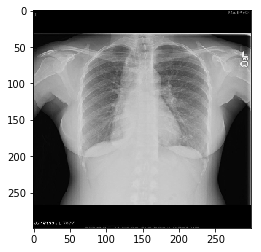

Predicted: [[0.]] Chest X-ray


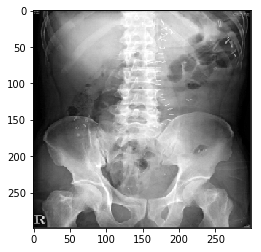

Predicted: [[0.99919957]] Abd X-ray


In [17]:
# import numpy and keras preprocessing libraries 
import numpy as np
from keras.preprocessing import image

# load, resize, and display test images 
img_path='/content/Open_I_abd_vs_CXRs/TEST/chest2.png' 
img_path2='/content/Open_I_abd_vs_CXRs/TEST/abd2.png'  
img = image.load_img(img_path, target_size=(img_width, img_height))
img2 = image.load_img(img_path2, target_size=(img_width, img_height))
plt.imshow(img)
plt.show()

# convert image to numpy array, so Keras can render a prediction 
img = image.img_to_array(img)

# expand array from 3 dimensions (height, width, channels) to 4 dimensions (batch size,
#height, width, channels)
# rescale pixel values to 0-1
x = np.expand_dims(img, axis=0
x = np.expand_dims(img, axis=0) * 1./255

# get prediction on test image                  
score = model.predict(x)
print('Predicted:', score, 'Chest X-ray' if score < 0.5 else 'Abd X-ray')

# display and render a prediction for the 2nd image
plt.imshow(img2)
plt.show()

img2 = image.img_to_array(img2)
x = np.expand_dims(img2, axis=0) * 1./255
score2 = model.predict(x)
print('Predicted:', score2, 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray')

The numbers within the brackets represent the probability of a chest vs. abdominal radiograph (range 0–1). A score close to 0 indicates a high confidence of a chest radiograph, and a score close to 1 indicates a high confidence of an abdominal radiograph

Lakhani, Paras et al. “Hello World Deep Learning in Medical Imaging.” Journal of digital imaging vol. 31,3 (2018): 283-289. doi:10.1007/s10278-018-0079-6

https://pdfs.semanticscholar.org/425f/c05d848f0318289f496f7b5e8cad26b123f6.pdf

**Ethical Dilemmas and Legal Risk**

Because applications of ML in radiology are new and few, there are more questions than answers when it comes to ethics. 

* Although deep learning works, it is often difficult to elucidate what is happening in the multiple hidden layers. Many commercially deployed models evolve as they are exposed to new data. For example, voice assistants developed by companies such as Apple and Google are constantly being improved as more people use the services and enlarge the pool of voice data available for training. The risk and benefit of training with live data will have to be established scientifically and constantly monitored for unintended consequences.

* At present the algorithms are being applied in highly controlled situations. But what happens when they are in wide distribution? Should individual institutions be allowed to augment validated models with additional training to develop setting-specific predictions? Or should ML products being used in practice be subject to code freezes, in which the model is not changed while in live practice? If models are allowed to evolve, how will they be regulated by the U.S. Food and Drug Administration (FDA)? If an entity develops a proprietary ML model and describes it as doing a particular task, such as identifying a specific pathologic entity, how should the model, and the associated claim, be verified?

* When ML or deep learning is used to drive subsequent action, additional ethical questions arise. Is the definition of the best algorithm that which improves the life span of each patient, no matter what the cost? If cost is factored into the algorithm, it is easy to see any number of untoward and unethical machine-generated outcomes. Suppose an unsupervised algorithm shows the pattern that for disease X a person with a high income with insurance Y usually receives an expensive treatment and does well but that a person with different insurance has access to only a less successful treatment. The algorithm would no doubt incorporate those different recommendations. At the least, these variations must be transparent, and the supervising physician alerted to what is happening.

* The FDA has not issued rules about test datasets, transparency, or verification procedures. It will probably evaluate models and associated test datasets on a case by case basis. How this will evolve is unclear at present. In addition, regulation that created the FDA was enacted before the availability of ML, and existing laws regarding devices are difficult to apply to ML algorithms.

* Liability issues may become more challenging as ML algorithms become more widespread. Currently most experts envision ML supporting a radiologist who would make the final decision or interpretation, thus retaining the primary responsibility or liability for any outcome. However, as ML algorithms become more advanced, this liability may shift toward the algorithm, companies, developers, and those responsible for training the algorithm, which will pose challenges in medical malpractice and liability in radiology.

Read More: https://www.ajronline.org/doi/full/10.2214/AJR.16.17224

Deep Learning for Medical Image Processing: Overview, Challenges and Future https://arxiv.org/pdf/1704.06825.pdf

Deep Learning from the Foundations https://course.fast.ai/part2.html